Make the notebook wider (if you think this makes the notebook look prettier)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Import the library with all predefine functions

In [2]:
import lazy_pipeline as lpipe

# Prepare the data

Load data

In [3]:
df = lpipe.load_data('tic_tac_toe')
print(df.shape)
df.head()

(958, 10)


,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True


Binarize data

In [4]:
y_name = 'Class'

In [5]:
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print(X.shape)
X.head()

(958, 27)


,top-left-square: b,top-left-square: o,top-left-square: x,top-middle-square: b,top-middle-square: o,top-middle-square: x,top-right-square: b,top-right-square: o,top-right-square: x,middle-left-square: b,...,middle-right-square: x,bottom-left-square: b,bottom-left-square: o,bottom-left-square: x,bottom-middle-square: b,bottom-middle-square: o,bottom-middle-square: x,bottom-right-square: b,bottom-right-square: o,bottom-right-square: x
0,False,False,True,False,False,True,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
4,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,True,False,False


Shuffle the data to drop any initial ordering of rows. For example, if the dataset is constructed first from all positive examples and then all negative examples.

_NB: Skip this step if your data is sequential and rows ordering is important. For example, if your dataset contains a "date" feature._

In [6]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

Represent data $X$ as list of subsets of attributes to better suit the theory.

In [7]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'bottom-left-square: x',
  'bottom-middle-square: o',
  'bottom-right-square: x',
  'middle-left-square: b',
  'middle-middle-square: x',
  'middle-right-square: x',
  'top-left-square: o',
  'top-middle-square: o',
  'top-right-square: o'}]

Assume that at the very begining, we know the labels only for the first 20% of rows.

In [8]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
n_train, n_test

(95, 863)

# Make predictions

Make predictions and measure time required to obtain these predictions

In [9]:
%%time
gen = lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 958/958 [00:14<00:00, 66.79it/s] 

CPU times: user 14.4 s, sys: 36.3 ms, total: 14.4 s
Wall time: 14.4 s


In [10]:
%%time
gen = list(lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 958/958 [00:00<00:00, 1911.24it/s]

CPU times: user 498 ms, sys: 7.81 ms, total: 505 ms
Wall time: 503 ms


Evaluate predictions

In [11]:
y_test = y[n_train:]

Here we decided to measure Accuracy and F1 score simply because there ones of the most popular scores. Feel free to use more elaborate scorings.

In [12]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

# Analyze results

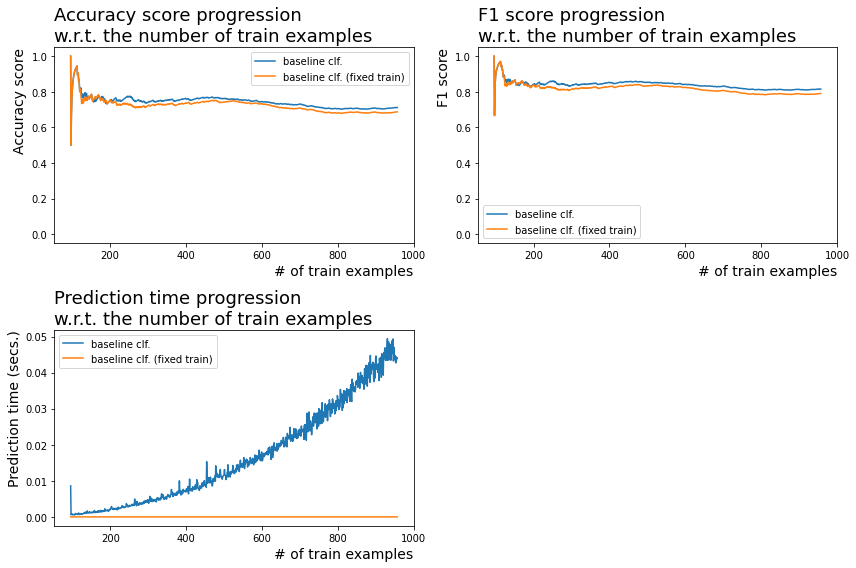

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

In conclusion:

...